In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
with open('../tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_detections = pickle.load(f)

In [4]:
ball_detections

[{},
 {1: [893.3170166015625, 615.1712036132812, 911.810302734375, 633.3427734375]},
 {1: [873.359619140625,
   637.5831298828125,
   894.268798828125,
   659.4693603515625]},
 {1: [857.3724975585938,
   644.1465454101562,
   882.7131958007812,
   669.2828979492188]},
 {},
 {},
 {1: [821.3065795898438, 687.060546875, 839.1983642578125, 705.0533447265625]},
 {1: [807.6063232421875,
   693.6937255859375,
   833.16455078125,
   718.8931884765625]},
 {1: [793.5411987304688,
   717.746826171875,
   816.1409912109375,
   740.03369140625]},
 {1: [774.0992431640625, 740.88330078125, 801.81884765625, 771.47119140625]},
 {1: [770.4186401367188,
   759.0009155273438,
   788.6464233398438,
   777.2177124023438]},
 {1: [775.2427368164062, 716.463623046875, 797.5493774414062, 740.3544921875]},
 {},
 {1: [794.1432495117188,
   643.406005859375,
   816.0305786132812,
   665.5103149414062]},
 {1: [801.6265869140625,
   603.1441040039062,
   825.30322265625,
   627.4209594726562]},
 {1: [812.67535400390

# interpolate

In [5]:
ball_positions = [x.get(1, []) for x in ball_detections]
# convert list to pandas df to interpolate the missing vals
df_ball_positions = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2'])

# interpolate missing vals
df_ball_positions = df_ball_positions.interpolate()
# since default direction is forward, we need to fill the 1st row
df_ball_positions = df_ball_positions.bfill()

df_ball_positions

,x1,y1,x2,y2
0,893.317017,615.171204,911.810303,633.342773
1,893.317017,615.171204,911.810303,633.342773
2,873.359619,637.583130,894.268799,659.469360
3,857.372498,644.146545,882.713196,669.282898
4,845.350525,658.451213,868.208252,681.206380
...,...,...,...,...
209,1182.298096,243.322693,1201.063965,265.716400
210,1182.157104,231.651215,1200.045410,249.390106
211,1180.354248,220.586792,1199.059204,241.902649
212,1177.729736,211.726166,1198.474243,231.593292


In [6]:
# get smooth detections in all frames
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2']) / 2
# reduce the effect of outliers
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

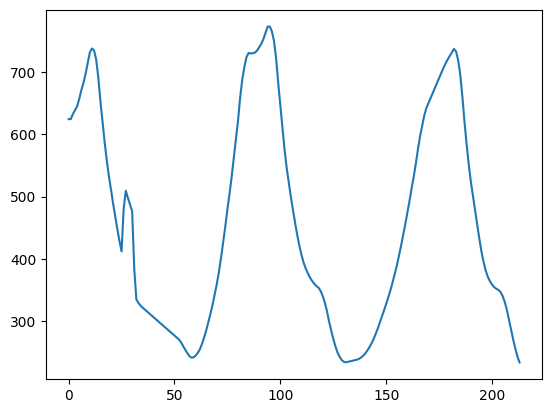

In [7]:
plt.plot(df_ball_positions['mid_y_rolling_mean'])

obs: ball changes y-direction once it is hit by a player

In [8]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()  # subtracts 2 consecutive rows from each other

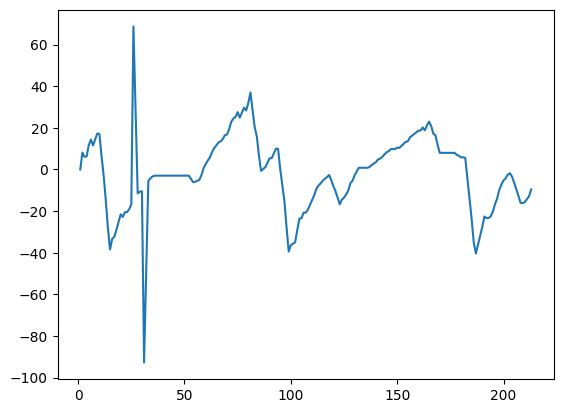

In [9]:
plt.plot(df_ball_positions['delta_y'])

# ball hit

In [17]:
# init a new col to track frames where ball is hit
df_ball_positions['ball_hit'] = 0

In [29]:
# atleast for 25 frames ball moves in one direction (increasing or decreasing)
min_change_frames_for_hit = 25
for i in range(1, len(df_ball_positions) - int(min_change_frames_for_hit*1.2)):
    negative_pos_change = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i+1] < 0
    positive_pos_change = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i+1] > 0

    # count pos changes in one direction
    if negative_pos_change or positive_pos_change:
        pos_change_count = 0
        for nxt_frame_idx in range(i+1, i + int(min_change_frames_for_hit * 1.2) + 1):
            negative_pos_change_nxt_frame = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[nxt_frame_idx] < 0
            positive_pos_change_nxt_frame = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[nxt_frame_idx] > 0

            if negative_pos_change and negative_pos_change_nxt_frame:
                pos_change_count += 1
            elif positive_pos_change and positive_pos_change_nxt_frame:
                pos_change_count += 1

        if pos_change_count > min_change_frames_for_hit - 1:
            df_ball_positions['ball_hit'].iloc[i] = 1

/tmp/ipykernel_5975/4216270723.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ball_positions['ball_hit'].iloc[i] = 1
/tmp/ipykernel_5975/4216270723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

[11, 27, 58, 95, 131, 182]

In [22]:
df_ball_positions[df_ball_positions['ball_hit'] == 1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,775.242737,716.463623,797.549377,740.354492,728.409058,737.575867,6.470422,1
27,880.221375,558.977997,903.584229,581.753693,570.365845,509.323077,28.596328,1
58,921.351318,230.657410,943.321045,253.245941,241.951675,241.617938,-2.637978,1
95,622.905029,746.716858,643.194794,765.732941,756.224899,772.889035,0.276498,1
131,712.118469,225.805125,730.562134,245.844635,235.824880,234.205973,-0.862664,1
182,1291.129761,738.863770,1313.555420,760.866821,749.865295,736.886646,5.568011,1


In [31]:
ball_hit_frames_idx = df_ball_positions[df_ball_positions['ball_hit'] == 1].index.tolist()
ball_hit_frames_idx

[11, 27, 58, 95, 131, 182]